In [1]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-latest-small'

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [3]:
[df, df_train,df_valid,df,df_ratings,dfflagtrain,dfflagvalid,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/reads.pkl','rb'))

In [4]:
df_ratings=df.pivot(index='movieId',columns='userId',values='rating')
df_ratings.fillna(0,inplace=True)

In [5]:
dfflagtrain=df.pivot(index='movieId',columns='userId',values='dstype_random_train')
dfflagtrain.head()
dfflagtrain.fillna(0,inplace=True)
df_train=df_ratings*dfflagtrain

In [6]:
dfflagvalid=df.pivot(index='movieId',columns='userId',values='dstype_random_valid')
dfflagvalid.head()
dfflagvalid.fillna(0,inplace=True)
df_valid=df_ratings*dfflagvalid

## Dataset and DataLoader

In [7]:
class autoencdata (Dataset):
    def __init__(self,dfX,dfXv):
        self.dfX,self.dfXv=dfX,dfXv
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values),torch.FloatTensor(self.dfXv.iloc[idx].values)

In [8]:
dstrain=autoencdata(df_train, df_valid)
#dsvalid=autoencdata(df_valid)

In [9]:
bs=64

In [11]:
# Create a DataLoader object
dltrain=DataLoader(dstrain,batch_size=bs,shuffle=False)
#dlvalid=DataLoader(dsvalid,batch_size=bs,shuffle=False) 

In [12]:
df['rating'].min(),df['rating'].max()

(0.5, 5.0)

In [13]:
df_train.shape

(9724, 610)

In [15]:
len(dltrain)

152

## Create the Model Architecture for the Encoder

In [16]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [17]:
class autoencoder (nn.Module):    
    def __init__(self,n_inp,hidden=[50,10],dropouts=[0,0,0],rating_range=[0.5,5]):
        super().__init__()
        self.n_inp,self.hidden,self.dropouts,self.rating_range=n_inp,hidden,dropouts,rating_range
        encoder=[hidden_layer(n_inp if i==0 else hidden[i-1],hidden[i],dropouts[i],\
                              nn.Sigmoid() if i<len(hidden)-1 else nn.Tanh()) for i in range(len(hidden))]
        self.encoder=nn.Sequential(*encoder)
        hidden=hidden[::-1]
        num_steps=len(hidden)-1
        dropouts=dropouts[num_steps:]
        decoder=[hidden_layer(hidden[i],hidden[i+1] if i<len(hidden)-1 else n_inp,dropouts[i]) for i in range(len(hidden)-1)]
        self.decoder=nn.Sequential(*decoder)
        self.fc=nn.Linear(hidden[-1],n_inp)
        self.initialize()
        self.criterion=nn.MSELoss()
    
    def initialize(self):
        for x in self.encoder:
            nn.init.kaiming_normal_(x[0].weight.data)
        for x in self.decoder:
            nn.init.kaiming_normal_(x[0].weight.data)

    def forward (self,Xb):
        
        encoded=self.encoder(Xb)
        decoded=self.decoder(encoded)
        out=self.fc(decoded)
        outv=out.clone()
        out[Xb==0]=0
        loss=self.criterion(out,Xb)
        return outv,loss, out

In [18]:
autoenc=autoencoder(df_train.shape[1],[50,10],[0,0,0])

In [19]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=610, out_features=50, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=10, bias=True)
      (1): Tanh()
      (2): Dropout(p=0)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
  )
  (fc): Linear(in_features=50, out_features=610, bias=True)
  (criterion): MSELoss()
)

In [20]:
for Xb, Xb_v in dltrain:
    print (Xb)
    break

tensor([[4.0000, 0.0000, 0.0000,  ..., 2.5000, 3.0000, 5.0000],
        [0.0000, 0.0000, 0.0000,  ..., 2.0000, 0.0000, 0.0000],
        [4.0000, 0.0000, 0.0000,  ..., 2.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.0000, 0.0000, 0.0000,  ..., 3.0000, 0.0000, 4.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [21]:
Xb.size()

torch.Size([64, 610])

In [22]:
Xb.squeeze(0)

tensor([[4.0000, 0.0000, 0.0000,  ..., 2.5000, 3.0000, 5.0000],
        [0.0000, 0.0000, 0.0000,  ..., 2.0000, 0.0000, 0.0000],
        [4.0000, 0.0000, 0.0000,  ..., 2.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.0000, 0.0000, 0.0000,  ..., 3.0000, 0.0000, 4.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [23]:
preds,loss,preds_train=autoenc.forward(Xb)

In [24]:
loss.backward()

In [25]:
preds.size()

torch.Size([64, 610])

In [26]:
nn.MSELoss

torch.nn.modules.loss.MSELoss

In [27]:
device="cuda:0"

In [28]:
wd=1e-4
#wd=1e-1

In [29]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
#optimizer=torch.optim.SGD(model_sentiment.parameters(),lr=1e-2,momentum=0.9, weight_decay=wd)
metric_fn=None

In [31]:
len(dltrain)

152

In [32]:
import matplotlib.pyplot as plt

In [33]:
dltrain.batch_size

64

In [34]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Xb_v,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss,preds_train=self.model(Xb)
        # denominator is the average of the error with non-zero ratings

        mean_corrector = Xb.size(0)*Xb.size(1)/(torch.sum(Xb > 0).float() + 1e-10)
        mean_corrector_v = Xb_v.size(0)*Xb_v.size(1)/(torch.sum(Xb_v > 0).float() + 1e-10)

        with torch.no_grad():
            
            preds[Xb_v==0]=0
            loss_v=self.model.criterion(preds,Xb_v)
            
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
                acc_v=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=torch.sqrt(loss.item()*mean_corrector)
        myloss_v=torch.sqrt(loss_v.item()*mean_corrector_v)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc,myloss_v,acc_v
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_loss_v,epoch_acc_v=0,0

        for Xb,Xb_v in iterator:
            Xb=Xb.to(self.device)
            Xb_v=Xb_v.to(self.device)
            #Xb=Xb.squeeze(0)
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc,loss_v,acc_v=self.fit(Xb,Xb_v,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            epoch_loss+=loss
            epoch_acc+=acc
            epoch_loss_v+=loss_v
            epoch_acc_v+=acc_v
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)} {epoch_loss_v/(k)} ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_loss_v=epoch_loss_v/len(iterator)
        epoch_acc_v=epoch_acc_v/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_loss_v,epoch_acc_v
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):
        
        
            
        
        for epoch in range(n_epochs):                

            loss,acc,lossv,accv=self.run_epoch(dltrain,True)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss}  Valid Loss:{lossv} ')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [35]:
autoenc=autoencoder(df_train.shape[1],[20,10],[0.6,0.6,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0)

In [36]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=610, out_features=20, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.6)
    )
    (1): Sequential(
      (0): Linear(in_features=20, out_features=10, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.6)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=20, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.6)
    )
  )
  (fc): Linear(in_features=20, out_features=610, bias=True)
  (criterion): MSELoss()
)

In [37]:
len(dltrain)

152

In [38]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

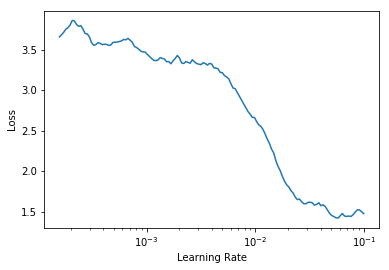

In [39]:
learner.plot_lrs(10)

In [40]:
autoenc=autoencoder(df_train.shape[1],[50,10],[0.25,0.25,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=3e-2,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=3e-2,end_lr=5e-4)

In [42]:
learner.run_epochs(dltrain,None,31)

Epoch:0 Learning rate 0.03 Weight Decay 1e-07 Train Loss:1.1161539554595947  Valid Loss:1.115892767906189 
Epoch:1 Learning rate 0.0038729833462074164 Weight Decay 1e-07 Train Loss:1.0356186628341675  Valid Loss:1.0415438413619995 
Epoch:2 Learning rate 0.0004999999999999999 Weight Decay 1e-07 Train Loss:0.9956214427947998  Valid Loss:1.022308111190796 
Epoch:3 Learning rate 0.03 Weight Decay 1e-07 Train Loss:1.0665830373764038  Valid Loss:1.058861255645752 
Epoch:4 Learning rate 0.010779123358892525 Weight Decay 1e-07 Train Loss:1.0262126922607422  Valid Loss:1.0235148668289185 
Epoch:5 Learning rate 0.003872983346207416 Weight Decay 1e-07 Train Loss:1.0000934600830078  Valid Loss:1.011268973350525 
Epoch:6 Learning rate 0.0013915788418568699 Weight Decay 1e-07 Train Loss:0.9661991000175476  Valid Loss:0.9827762246131897 
Epoch:7 Learning rate 0.0004999999999999998 Weight Decay 1e-07 Train Loss:0.9558252096176147  Valid Loss:0.9680547118186951 
Epoch:8 Learning rate 0.03 Weight Decay 

In [45]:
autoenc=autoencoder(df_train.shape[1],[50,10],[0.25,0.25,0]).to(device)
wd=1e-6
optimizer=torch.optim.Adam(autoenc.parameters(),lr=3e-2,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0,start_lr=3e-2,end_lr=5e-4)

In [46]:
learner.run_epochs(dltrain,None,63)

Epoch:0 Learning rate 0.03 Weight Decay 1e-06 Train Loss:1.121293306350708  Valid Loss:1.1241103410720825 
Epoch:1 Learning rate 0.03 Weight Decay 1e-06 Train Loss:1.0636924505233765  Valid Loss:1.0565012693405151 
Epoch:2 Learning rate 0.03 Weight Decay 1e-06 Train Loss:1.049501895904541  Valid Loss:1.0456959009170532 
Epoch:3 Learning rate 0.03 Weight Decay 1e-06 Train Loss:1.054572582244873  Valid Loss:1.045621633529663 
Epoch:4 Learning rate 0.03 Weight Decay 1e-06 Train Loss:1.0274609327316284  Valid Loss:1.0315592288970947 
Epoch:5 Learning rate 0.03 Weight Decay 1e-06 Train Loss:1.012212872505188  Valid Loss:1.0096160173416138 
Epoch:6 Learning rate 0.03 Weight Decay 1e-06 Train Loss:0.9999094605445862  Valid Loss:0.9935700297355652 
Epoch:7 Learning rate 0.03 Weight Decay 1e-06 Train Loss:0.9821175336837769  Valid Loss:0.9778319001197815 
Epoch:8 Learning rate 0.03 Weight Decay 1e-06 Train Loss:0.9813492298126221  Valid Loss:0.9774125814437866 
Epoch:9 Learning rate 0.03 Weight

In [47]:
item_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
item_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [49]:
item_mtx_1_weights.shape, item_mtx_2_weights.shape

((50, 610), (10, 50))

In [51]:
df_train.shape

(9724, 610)

In [54]:
from scipy.special import expit

In [58]:
np.tanh(expit(df_train@item_mtx_1_weights.T)@item_mtx_2_weights.T)

,0,1,2,3,4,5,6,7,8,9
movieId,,,,,,,,,,
1,-1.000000,-1.000000,0.997642,0.999984,-1.000000,-0.998100,0.961256,0.172133,-0.999995,0.999146
2,-1.000000,-0.999997,-0.698399,1.000000,-1.000000,-0.997402,0.968649,0.969533,-0.995085,-0.879193
3,-1.000000,0.918195,-1.000000,1.000000,-0.579384,-0.997684,0.973646,0.999997,0.998660,-0.999999
4,-1.000000,0.049580,-0.999999,1.000000,-0.326456,-0.994506,0.900776,0.998242,0.998951,-0.999805
5,-1.000000,-0.706495,-0.999985,1.000000,-0.996118,-0.992763,0.954681,0.999275,0.551115,-0.999920
6,-1.000000,-1.000000,0.997260,0.999933,-1.000000,-0.998133,0.953757,0.701939,-0.999873,0.985551
7,-1.000000,-0.604212,-0.999999,1.000000,-0.983496,-0.993037,0.946007,0.999249,0.845868,-0.999964
8,-1.000000,0.659138,-1.000000,1.000000,-0.825122,-0.998228,0.955654,0.999956,0.998201,-0.999997
9,-1.000000,0.999210,-1.000000,1.000000,0.946655,-0.995916,0.965868,0.999993,0.999756,-1.000000


### OLD RESULTS

In [50]:
learner.run_epochs(dltrain,dlvalid,31)

Epoch:0 Learning rate 0.03 Weight Decay 1e-07 Train Loss:1.1851178407669067  Valid Loss:1.0310707092285156 
Epoch:1 Learning rate 0.0038729833462074164 Weight Decay 1e-07 Train Loss:1.003689169883728  Valid Loss:0.9441735148429871 
Epoch:2 Learning rate 0.0004999999999999999 Weight Decay 1e-07 Train Loss:0.9867559671401978  Valid Loss:0.9520727396011353 
Epoch:3 Learning rate 0.03 Weight Decay 1e-07 Train Loss:1.0897201299667358  Valid Loss:0.9591107964515686 
Epoch:4 Learning rate 0.010779123358892525 Weight Decay 1e-07 Train Loss:0.9829736351966858  Valid Loss:0.9768510460853577 
Epoch:5 Learning rate 0.003872983346207416 Weight Decay 1e-07 Train Loss:0.948708176612854  Valid Loss:0.9342473745346069 
Epoch:6 Learning rate 0.0013915788418568699 Weight Decay 1e-07 Train Loss:0.9373030662536621  Valid Loss:0.9225978851318359 
Epoch:7 Learning rate 0.0004999999999999998 Weight Decay 1e-07 Train Loss:0.9346903562545776  Valid Loss:0.9241189360618591 
Epoch:8 Learning rate 0.03 Weight Deca

In [51]:
len(dltrain)

152

In [52]:
autoenc.encoder[0][0].weight.data.shape

torch.Size([50, 610])

In [53]:
autoenc.encoder[1][0].weight.data.shape

torch.Size([10, 50])

In [54]:
item_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
item_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [55]:
import pickle
pickle.dump([item_mtx_1_weights,item_mtx_2_weights],open(f'{DATAPATH}/inter/item_autoenc_weights.pkl','wb'))